# Predicting Subscription Churn using the Lifelines Package

**Goal**: The goal of this Jupyter tutorial is to evaluate the subscription churn using several survival methods including Kaplan-Meier estimation and Cox Proportional Hazards regression.

In [1]:
# Load Standard Libraries
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

# Set Preferred Plotting Style
sns.set_style("darkgrid")
%matplotlib inline

# Load Survival Libraries
from lifelines import CoxPHFitter
from lifelines.plotting import plot_lifetimes
from lifelines import KaplanMeierFitter
from lifelines.utils.sklearn_adapter import sklearn_adapter
from lifelines.calibration import survival_probability_calibration

# Load Sklearn Helpers
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV

In [2]:
# Import data
df = pd.read_csv('../data/9mo_pull.csv')

In [3]:
df.head()

,member_id,tier,country,source,tenure,active
0,12428284,Platinum,Germany,referral,6,0
1,39743027,Platinum,France,referral,1,0
2,59559187,Silver,UK,organic,1,0
3,46170183,Silver,UK,organic,4,0
4,14600427,Gold,France,organic,1,0


In [4]:
df.shape

(99944, 6)

## Survival Analysis

Let's experiment with some survival analysis methods using the lifelines package.

In [5]:
# Convert active to churn:
df['churn'] = df['active'] == 0
df = df.drop(['member_id','active'], axis = 1)

X = df[['source','country','tier']]
y = df[['churn','tenure']]

In [6]:
df.head()

,tier,country,source,tenure,churn
0,Platinum,Germany,referral,6,True
1,Platinum,France,referral,1,True
2,Silver,UK,organic,1,True
3,Silver,UK,organic,4,True
4,Gold,France,organic,1,True


In [7]:
X.head()

,source,country,tier
0,referral,Germany,Platinum
1,referral,France,Platinum
2,organic,UK,Silver
3,organic,UK,Silver
4,organic,France,Gold


In [8]:
y.head()

,churn,tenure
0,True,6
1,True,1
2,True,1
3,True,4
4,True,1


In [9]:
n_censored = y.shape[0] - y["churn"].sum()
print("%.1f%% of records are censored" % (n_censored / y.shape[0] * 100))

7.5% of records are censored


The estimated survival function can be estimated by the kaplan-meier estimator. 

/Users/RobertSmith/data-science-projects/CustomerChurn/venv/lib/python3.8/site-packages/lifelines/plotting.py:663: UserWarning: For less visual clutter, you may want to subsample to less than 25 individuals.
  warnings.warn("For less visual clutter, you may want to subsample to less than 25 individuals.")


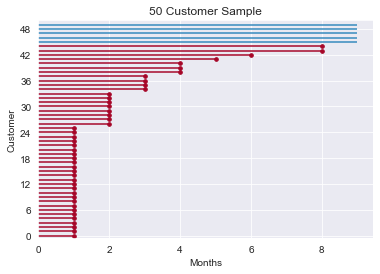

In [10]:
sample = y[0:50]
ax = plot_lifetimes(sample["tenure"], 
                    event_observed = sample["churn"])
plt.xlabel("Months")
plt.ylabel("Customer")
plt.title("50 Customer Sample");

In [11]:
kmf = KaplanMeierFitter()
kmf.fit(y["tenure"], event_observed = y["churn"])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 99944 total observations, 7492 right-censored observations>

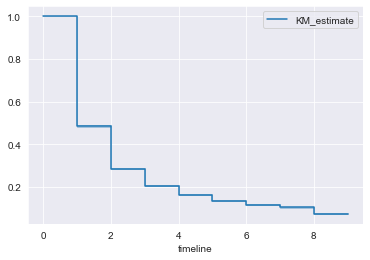

In [12]:
kmf.plot();

The survival curve above indicates that 20% of customers continue their subscription past 3 months. Next, let's look at the survival curves for the three factors in our data set: tier, lead source, and country

In [13]:
kmf.median_survival_time_

1.0

In [14]:
from lifelines.utils import median_survival_times
median_ci = median_survival_times(kmf.confidence_interval_)
print(median_ci)

     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                     1.0                     1.0


In [15]:
def km_plot(X, y, feature):
    for value in X[feature].unique():
        index = X[feature] == value
        kmf.fit(y.loc[index,"tenure"], y.loc[index, "churn"], label = value)
        kmf.plot()
    plt.title(f"Kaplan-Meier Curve by {feature}")
    plt.ylabel("Est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")

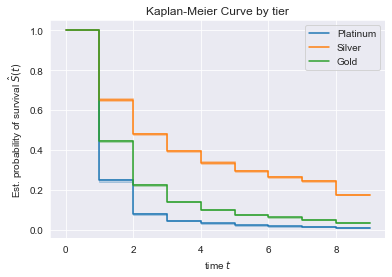

In [16]:
km_plot(X, y, "tier")

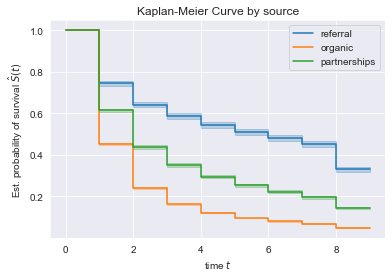

In [17]:
km_plot(X, y, "source")

US             18425
UK             18033
Germany        17689
France         10235
Netherlands     9693
Italy           9528
Spain           9048
Canada          7293
Name: country, dtype: int64


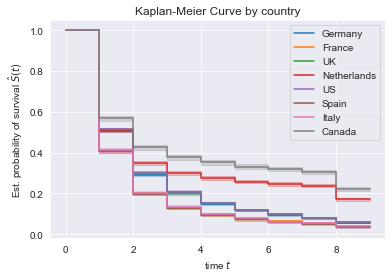

In [18]:
print(X["country"].value_counts())
km_plot(X, y, "country")

The survival curves for the different tiers are substantially different, particularly for Silver tier customers, referral sources, and customers from the Netherlands and Canada.

Next, let's build a simple data processing and model pipeline with our data using a Cox Proportional Hazards Model.

In [19]:
df_dummies = pd.get_dummies(df, drop_first = True)
df_dummies.head()

,tenure,churn,tier_Platinum,tier_Silver,country_France,country_Germany,country_Italy,country_Netherlands,country_Spain,country_UK,country_US,source_partnerships,source_referral
0,6,True,1,0,0,1,0,0,0,0,0,0,1
1,1,True,1,0,1,0,0,0,0,0,0,0,1
2,1,True,0,1,0,0,0,0,0,1,0,0,0
3,4,True,0,1,0,0,0,0,0,1,0,0,0
4,1,True,0,0,1,0,0,0,0,0,0,0,0


In [20]:
cph = CoxPHFitter()
cph.fit(df_dummies, duration_col='tenure', event_col='churn')

cph.print_summary()  # access the results using cph.summary

<lifelines.CoxPHFitter: fitted with 99944 total observations, 7492 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
      baseline estimation = breslow
   number of observations = 99944
number of events observed = 92452
   partial log-likelihood = -979822.84
         time fit was run = 2020-08-19 02:32:43 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                   
tier_Platinum         0.45       1.56       0.01             0.43             0.47                 1.53                 1.60
tier_Silver          -0.73       0.48       0.01            -0.75            -0.72                 0.47                 0.49
country_France        0.56       1.75       0.02             0.53             0.60                 1.70                 1.81
country_Germany       0.22       1.25       0.02             0.19             0.26                 1.21                 1.29
country_Italy         0.56       1.75       0.02             0.53             0.60                 1.70                 1.81
country_Netherlands   0.12       1.13       0.02             0.09             0.16                 1.09                 1.17
country_Spain         0.57       1.77       0.02             0.54             0.60                 1.71                 1.83
country_UK            0.24       1.27       0.02             0.21             0.27                 1.23                 1.31
country_US            0.24       1.27       0.02             0.21             0.27                 1.23                 1.31
source_partnerships  -0.58       0.56       0.01            -0.60            -0.56                 0.55                 0.57
source_referral      -1.26       0.28       0.02            -1.29            -1.22                 0.27                 0.29
                         z      p   -log2(p)
covariate                                   
tier_Platinum        41.87 <0.005        inf
tier_Silver         -88.74 <0.005        inf
country_France       33.05 <0.005     793.21
country_Germany      14.15 <0.005     148.62
country_Italy        32.63 <0.005     773.49
country_Netherlands   7.12 <0.005      39.75
country_Spain        32.81 <0.005     781.87
country_UK           15.08 <0.005     168.26
country_US           15.02 <0.005     167.05
source_partnerships -55.18 <0.005        inf
source_referral     -69.64 <0.005        inf
---
Concordance = 0.68
Partial AIC = 1959667.69
log-likelihood ratio test = 22955.46 on 11 df
-log2(p) of ll-ratio test = inf

**Note:** The baseline hazard is based on a Gold `tier` customer from the `country` of Canada that was sourced through an organic `source`.  


### Model Interpretation
Based on the coefficient table above, a customer in the Platinum `tier` has a 56% higher chance of churn over the baseline hazard (which is based on the Gold `tier`). Similarly, customers in the Silver `tier` has a 52% lower chance of churn over the baseline hazard. These results are consistent with the kaplan-meier curve for the `tier` feature generated above.

### Goodness of Fit

ICI =  0.050171859338496654
E50 =  0.05038557465930105


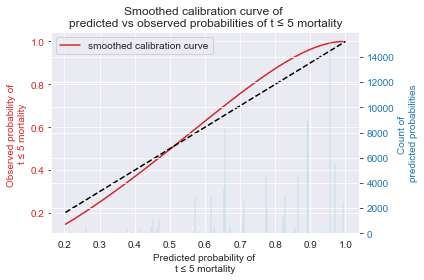

In [21]:
survival_probability_calibration(cph, df_dummies, t0=5);

In [71]:
cph.check_assumptions(df_dummies)

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.





1. Variable 'tier_Platinum' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['tier_Platinum', ...]` in
the call in `.fit`. See documentation in link [E] below.

2. Variable 'tier_Silver' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['tier_Silver', ...]` in the
call in `.fit`. See documentation in link [E] below.

3. Variable 'country_France' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['country_France', ...]` in
the call in `.fit`. See documentation in link [E] below.

4. Variable 'country_Germany' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['country_Germany', ...]` in
the call in `.fit`. See documentation in link [E] below.

5. Variable 'country_Italy' failed the non-p

In [22]:
cph.log_likelihood_ratio_test().print_summary()

In [23]:
cph.predict_survival_function(df_dummies) # Note each column is an observation and each row is a month

,0,1,2,3,4,5,6,7,8,9,...,99934,99935,99936,99937,99938,99939,99940,99941,99942,99943
1.0,0.777974,0.703290,0.759186,0.759186,0.452867,0.761990,0.851748,0.449568,0.850099,0.759492,...,0.761990,0.599910,0.599910,0.452867,0.726474,0.568347,0.759186,0.564009,0.568347,0.452867
2.0,0.613714,0.504348,0.585221,0.585221,0.214282,0.589431,0.731947,0.211257,0.729194,0.585680,...,0.589431,0.370217,0.370217,0.214282,0.537183,0.333282,0.585221,0.328353,0.333282,0.214282
3.0,0.508326,0.387270,0.475914,0.475914,0.118253,0.480666,0.648907,0.115946,0.645527,0.476432,...,0.480666,0.252303,0.252303,0.118253,0.422646,0.218104,0.475914,0.213646,0.218104,0.118253
4.0,0.434032,0.310319,0.400153,0.400153,0.071829,0.405087,0.586575,0.070104,0.582809,0.400690,...,0.405087,0.182920,0.182920,0.071829,0.345649,0.152838,0.400153,0.148994,0.152838,0.071829
5.0,0.377605,0.255277,0.343442,0.343442,0.046287,0.348388,0.536619,0.044993,0.532600,0.343980,...,0.348388,0.137773,0.137773,0.046287,0.289502,0.111715,0.343442,0.108443,0.111715,0.046287
6.0,0.334992,0.215825,0.301153,0.301153,0.031723,0.306027,0.497083,0.030729,0.492904,0.301682,...,0.306027,0.107975,0.107975,0.031723,0.248578,0.085325,0.301153,0.082524,0.085325,0.031723
7.0,0.300252,0.185114,0.267060,0.267060,0.022457,0.271819,0.463488,0.021684,0.459203,0.267576,...,0.271819,0.086407,0.086407,0.022457,0.216243,0.066691,0.267060,0.064287,0.066691,0.022457
8.0,0.228191,0.125991,0.197613,0.197613,0.009447,0.201947,0.388920,0.009049,0.384509,0.198082,...,0.201947,0.049428,0.049428,0.009447,0.152489,0.035961,0.197613,0.034375,0.035961,0.009447
9.0,0.228191,0.125991,0.197613,0.197613,0.009447,0.201947,0.388920,0.009049,0.384509,0.198082,...,0.201947,0.049428,0.049428,0.009447,0.152489,0.035961,0.197613,0.034375,0.035961,0.009447


In [24]:
# filter down to just censored subjects to predict remaining survival
censored_subjects = df_dummies.loc[~df_dummies['churn'].astype(bool)]
censored_subjects_last_obs = censored_subjects['tenure']
censored_subjects.head()

,tenure,churn,tier_Platinum,tier_Silver,country_France,country_Germany,country_Italy,country_Netherlands,country_Spain,country_UK,country_US,source_partnerships,source_referral
8,9,False,0,0,0,0,0,0,0,0,1,0,1
19,9,False,0,1,0,0,0,1,0,0,0,0,0
28,9,False,0,1,0,0,0,1,0,0,0,0,0
30,9,False,0,0,0,0,0,0,0,0,1,0,1
31,9,False,0,0,0,0,0,1,0,0,0,1,0


In [25]:
censored_subjects.shape

(7492, 13)

In [26]:
censored_subjects_last_obs

8        9
19       9
28       9
30       9
31       9
        ..
99923    9
99928    9
99929    9
99938    9
99939    9
Name: tenure, Length: 7492, dtype: int64

In [29]:
cph.predict_survival_function(censored_subjects, times = list(range(1,4)), conditional_after = censored_subjects_last_obs)

,8,19,28,30,31,64,71,86,99,115,...,99881,99903,99904,99911,99918,99923,99928,99929,99938,99939
1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [30]:
cph.predict_median(censored_subjects, conditional_after=censored_subjects_last_obs)

8        inf
19       inf
28       inf
30       inf
31       inf
        ... 
99923    inf
99928    inf
99929    inf
99938    inf
99939    inf
Name: 0.5, Length: 7492, dtype: float64

The reason that the censored observations don't have meaningful predictions is a result of the model's inability to extrapolate beyond 9 months.  

Next, we can create four synthetic customers and estimate their survival curve.

In [77]:
df_dummies.head()

,tenure,churn,tier_Platinum,tier_Silver,country_France,country_Germany,country_Italy,country_Netherlands,country_Spain,country_UK,country_US,source_partnerships,source_referral
0,6,True,1,0,0,1,0,0,0,0,0,0,1
1,1,True,1,0,1,0,0,0,0,0,0,0,1
2,1,True,0,1,0,0,0,0,0,1,0,0,0
3,4,True,0,1,0,0,0,0,0,1,0,0,0
4,1,True,0,0,1,0,0,0,0,0,0,0,0


In [78]:
df_dummies.shape

(99944, 13)

In [79]:
x_new = pd.DataFrame.from_dict({
    1: [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],  # Platinum, Netherlands, Referral
    2: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # Gold, Canada, Organic
    3: [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],  # Gold, Germany, Partnerships
    4: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]}, # Silver, Canada , Referral
     columns=df_dummies.columns[2:], orient='index')
x_new

,tier_Platinum,tier_Silver,country_France,country_Germany,country_Italy,country_Netherlands,country_Spain,country_UK,country_US,source_partnerships,source_referral
1,1,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,1


In [80]:
pred_surv = cph.predict_survival_function(x_new)
pred_surv

,1,2,3,4
1.0,0.796884,0.636644,0.729249,0.940172
2.0,0.643055,0.415574,0.541181,0.886947
3.0,0.542314,0.296132,0.427011,0.846820
4.0,0.470104,0.222878,0.350059,0.814571
5.0,0.414473,0.173495,0.293817,0.787167
6.0,0.371935,0.139880,0.252741,0.764343
7.0,0.336874,0.114878,0.220231,0.744054
8.0,0.262833,0.070125,0.155950,0.695531
9.0,0.262833,0.070125,0.155950,0.695531


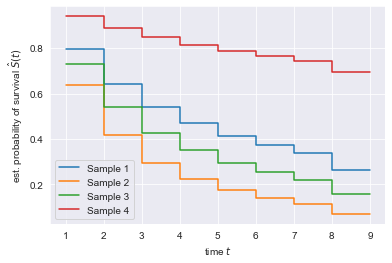

In [81]:
for col in pred_surv.columns:
    plt.step(pred_surv.index, pred_surv[col], where="post", label="Sample %d" % (col))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")
plt.show()

## Feature Selection: Which Variable is Most Predictive?

In [33]:
df.head()

,tier,country,source,tenure,churn
0,Platinum,Germany,referral,6,True
1,Platinum,France,referral,1,True
2,Silver,UK,organic,1,True
3,Silver,UK,organic,4,True
4,Gold,France,organic,1,True


In [34]:
pd.get_dummies(df)

,tenure,churn,tier_Gold,tier_Platinum,tier_Silver,country_Canada,country_France,country_Germany,country_Italy,country_Netherlands,country_Spain,country_UK,country_US,source_organic,source_partnerships,source_referral
0,6,True,0,1,0,0,0,1,0,0,0,0,0,0,0,1
1,1,True,0,1,0,0,1,0,0,0,0,0,0,0,0,1
2,1,True,0,0,1,0,0,0,0,0,0,1,0,1,0,0
3,4,True,0,0,1,0,0,0,0,0,0,1,0,1,0,0
4,1,True,1,0,0,0,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99939,9,False,1,0,0,0,0,1,0,0,0,0,0,1,0,0
99940,6,True,0,0,1,0,0,0,0,0,0,1,0,1,0,0
99941,2,True,1,0,0,0,0,0,0,0,0,1,0,1,0,0
99942,3,True,1,0,0,0,0,1,0,0,0,0,0,1,0,0


In [35]:
def fit_and_score_features(X):
    n_features = X.shape[1] - 2
    scores = np.empty(n_features)
    m = CoxPHFitter()
    for j in range(n_features):
        Xj = X.iloc[:, j:j+1]
        Xj = pd.get_dummies(Xj, drop_first=True)
        Xj = pd.concat([Xj,df[["tenure","churn"]]], axis = 1)
        m.fit(Xj, duration_col = "tenure", event_col = "churn")
        scores[j] = m.score(Xj, scoring_method = "concordance_index")
    return scores

scores = fit_and_score_features(df)
pd.Series(scores, index=df.columns[0:3]).sort_values(ascending=False)

tier       0.623717
source     0.566107
country    0.560810
dtype: float64

The scores indicate that the `tier` feature is the most predictive, followed by the `source`, and finally `country`. 

In [36]:
def fit_and_score(X,y):
    X = pd.get_dummies(X)
    n_features = X.shape[1]
    scores = {}
    m = CoxPHFitter()
    for j in range(n_features):
        Xj = X.iloc[:, j:j+1]
        Xj = pd.concat([Xj,y], axis = 1)
        m.fit(Xj, duration_col = "tenure", event_col = "churn")
        scores[Xj.columns[0]] = m.score(Xj, scoring_method = "concordance_index")
    return scores

scores = fit_and_score(X, y)

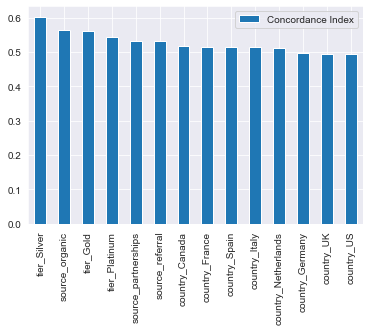

In [37]:
pd.DataFrame(scores.values(), index = scores.keys(), columns = ["Concordance Index"]).sort_values("Concordance Index", ascending = False).plot(kind = "bar");

## Create Model Pipelines with Cross-Validation

In [38]:
df.head()

,tier,country,source,tenure,churn
0,Platinum,Germany,referral,6,True
1,Platinum,France,referral,1,True
2,Silver,UK,organic,1,True
3,Silver,UK,organic,4,True
4,Gold,France,organic,1,True


In [39]:
base_class = sklearn_adapter(CoxPHFitter, event_col="churn")
model = base_class()

In [49]:
X = df[['source','country','tier', 'churn']]
X = pd.get_dummies(X, drop_first = True)
y = df[['tenure']]

param_grid = {'penalizer': np.arange(0,1,.1),
              'l1_ratio': [0, 1/3, 2/3, 1]}

gcv = GridSearchCV(model, param_grid, return_train_score=True, cv=3)
gcv.fit(X, y)

gcv_results = pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)

KeyboardInterrupt: 

In [ ]:
gcv_results

## Concluding Remarks

* Promotion of Silver Tier above others.
* Increase marketing in the Netherlands and Canada.
* Re-visit partnership agreements.
* Develop referral incentive to increase number of referrals. 